In [1]:
import numpy as np, pandas as pd

from matplotlib.pyplot import subplots
from sklearn.linear_model import (
    LinearRegression, LogisticRegression, Lasso
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [3]:
from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary
from torchvision.io import read_image

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [9]:
# NB: Was before: "from pytorch_lightning.utilities.seed import seed_everything"
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


In [10]:
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import (
    Resize, Normalize, CenterCrop, ToTensor
)

In [11]:
from ISLP.torch import (
    SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
)

In [12]:
from ISLP.torch.imdb import (
    load_lookup, load_tensor, load_sparse, load_sequential
)

In [13]:
from glob import glob
import json

## Single Layer Network on Hitters Data

In [14]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [15]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=1/3, random_state=1
)

In [18]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146243

In [19]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])

In [20]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}

In [21]:
cv = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(
    lasso, param_grid, cv=cv, scoring='neg_mean_absolute_error'
)
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

In [22]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.2382010799497

In [23]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel , self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [24]:
hit_model = HittersModel(X.shape[1])

In [25]:
summary(
    hit_model,
    input_size=X_train.shape,
    col_names=['input_size', 'output_size', 'num_params']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [27]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

In [28]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [29]:
max_num_workers = rec_num_workers()

In [30]:
hit_dm = SimpleDataModule(
    hit_train,
    hit_test,
    batch_size=32,
    num_workers=min(4, max_num_workers),
    validation=hit_test
)

In [31]:
hit_module = SimpleModule.regression(hit_model, metrics={'mae':MeanAbsoluteError()})

In [32]:
hit_logger = CSVLogger('logs', name='hitters')

In [33]:
hit_trainer = Trainer(
    deterministic=True,
    max_epochs=50,
    log_every_n_steps=5,
    logger=hit_logger,
    callbacks=[ErrorTracker()]
)
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=50` reached.


In [34]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      107904.6484375       │
│         test_mae          │    221.83148193359375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 107904.6484375, 'test_mae': 221.83148193359375}]

In [35]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [36]:
def summary_plot(
    results,
    ax,
    col='loss',
    valid_legend='Validation',
    training_legend='Training',
    ylabel='Loss',
    fontsize=20
):
    for (column, color, label) in zip(
        [f'train_{col}_epoch', f'valid_{col}'],
        ['black','red'],
        [training_legend,valid_legend]
    ):
        results.plot(
            x='epoch',
            y=column,
            label=label,
            marker='o',
            color=color,
            ax=ax
        )
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    
    return ax

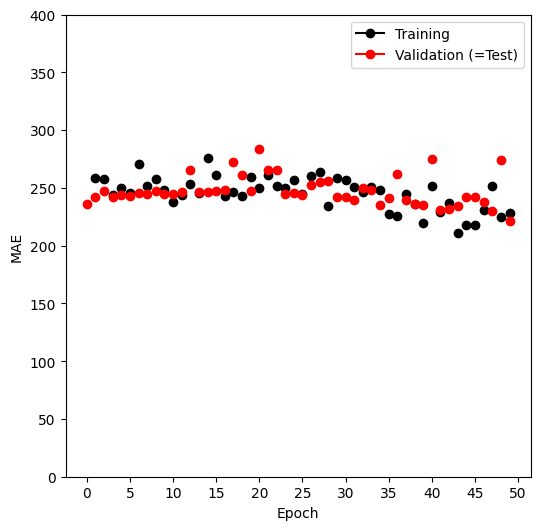

In [37]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(
    hit_results,
    ax,
    col='mae',
    ylabel='MAE',
    valid_legend='Validation (=Test)'
)
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int))

In [38]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(221.8315, grad_fn=<MeanBackward0>)

In [39]:
del(
    Hitters,
    hit_model, 
    hit_dm,
    hit_logger,
    hit_test, 
    hit_train,
    X, 
    Y,
    X_test, 
    X_train,
    Y_test, 
    Y_train,
    X_test_t, 
    Y_test_t,
    hit_trainer, 
    hit_module
)

## Multilayer Network on Hitters Data

In [41]:
mnist_train, mnist_test = [
    MNIST(
        root='data',
        train=train,
        download=True,
        transform=ToTensor()
    ) for train in [True, False]
]
mnist_train

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 5.41MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 270kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.44MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.97MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [43]:
mnist_dm = SimpleDataModule(
    mnist_train,
    mnist_test,
    validation=0.2,
    num_workers=max_num_workers,
    batch_size=256
)

In [44]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [45]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self._forward(x)

In [46]:
mnist_model = MNISTModel()

In [47]:
mnist_model(X_).size()

torch.Size([256, 10])

In [48]:
summary(
    mnist_model,
    input_data=X_,
    col_names=['input_size', 'output_size', 'num_params']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [50]:
# NB: Old "mnist_module = SimpleModule.classification(mnist_model)" does not work, 
# yields error "missing 1 required positional argument: 'num_classes'"
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

In [51]:
mnist_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    logger=mnist_logger,
    callbacks=[ErrorTracker()]
)
mnist_trainer.fit(mnist_module, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


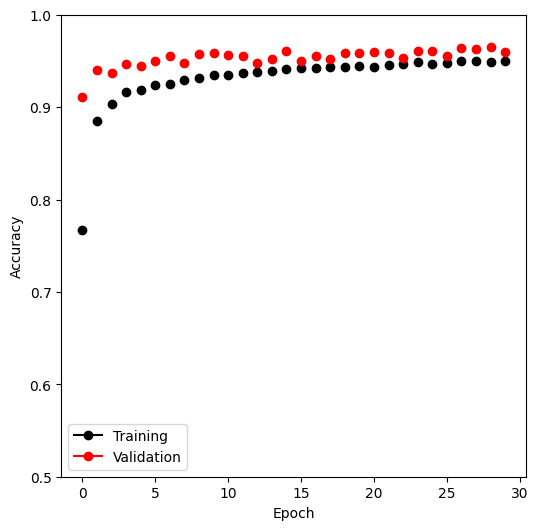

In [52]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(
    mnist_results,
    ax,
    col='accuracy',
    ylabel='Accuracy'
)

ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [53]:
mnist_trainer.test(mnist_module, datamodule=mnist_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9620000123977661     │
│         test_loss         │    0.15120187401771545    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.15120187401771545, 'test_accuracy': 0.9620000123977661}]

In [55]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 10)
        )
        
    def forward(self, x):
        return self.linear(x)
        
mlr_model = MNIST_MLR()
# NB: Old "mlr_module = SimpleModule.classification(mlr_model)" does not work, 
# yields error "missing 1 required positional argument: 'num_classes'"
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [56]:
mlr_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    callbacks=[ErrorTracker()]
)
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


In [57]:
mlr_trainer.test(mlr_module, datamodule=mnist_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9168999791145325     │
│         test_loss         │    0.34429067373275757    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.34429067373275757, 'test_accuracy': 0.9168999791145325}]

In [58]:
del(
    mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer
)

## Convolutional neural networks

In [59]:
cifar_train, cifar_test = [
    CIFAR100(
        root="data",
        train=train,
        download=True
    ) for train in [True, False]
]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169M/169M [00:09<00:00, 17.4MB/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [60]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])
cifar_train = TensorDataset(cifar_train_X, torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X, torch.tensor(cifar_test.targets))

In [61]:
cifar_dm = SimpleDataModule(
    cifar_train,
    cifar_test,
    validation=0.2,
    num_workers=max_num_workers,
    batch_size=128
)

In [62]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


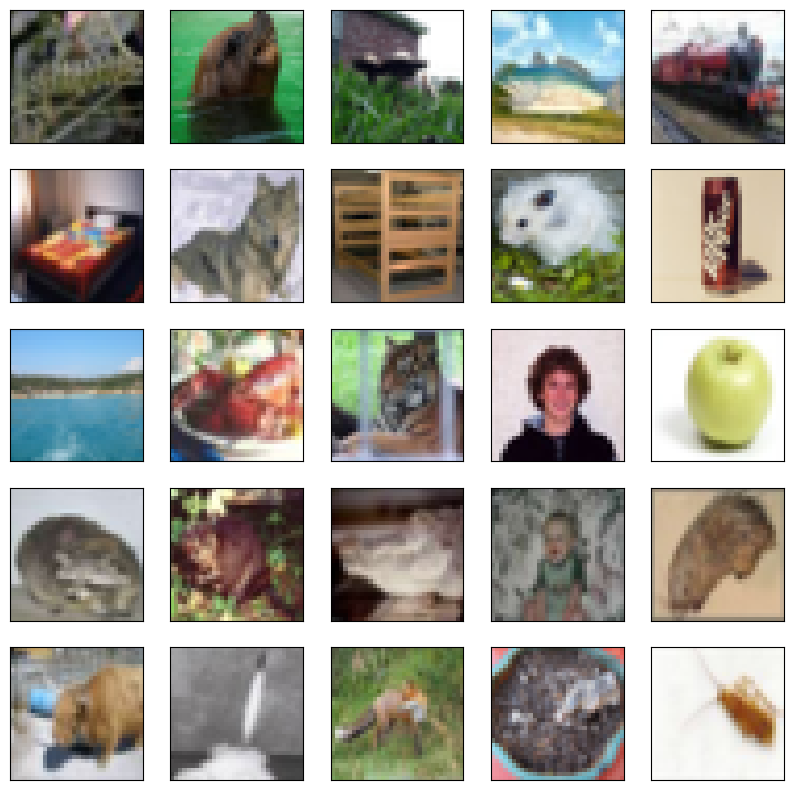

In [63]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(
    np.arange(len(cifar_train)), 
    25,
    replace=False
).reshape((5,5))

for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(
            np.transpose(cifar_train[idx][0], [1,2,0]),
            interpolation=None
        )
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [64]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BuildingBlock , self).__init__()
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3,3),
            padding='same'
        )
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [65]:
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        
        sizes = [(3,32), (32,64), (64,128), (128,256)]
        self.conv = nn.Sequential(
            *[BuildingBlock(in_, out_) for in_, out_ in sizes]
        )
        self.output = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*2*256, 512),
            nn.ReLU(),
            nn.Linear(512, 100)
        )
        
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        
        return self.output(val)

In [66]:
cifar_model = CIFARModel()

summary(
    cifar_model,
    input_data=X_,
    col_names=['input_size', 'output_size', 'num_params']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [68]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)

# NB: Old "cifar_module = SimpleModule.classification(cifar_model, optimizer=optimizer)" 
# does not work, yields error "missing 1 required positional argument: 'num_classes'"
cifar_module = SimpleModule.classification(
    cifar_model,
    optimizer=cifar_optimizer,
    num_classes=100
)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [69]:
cifar_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    logger=cifar_logger,
    callbacks=[ErrorTracker()]
)

cifar_trainer.fit(cifar_module, datamodule=cifar_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


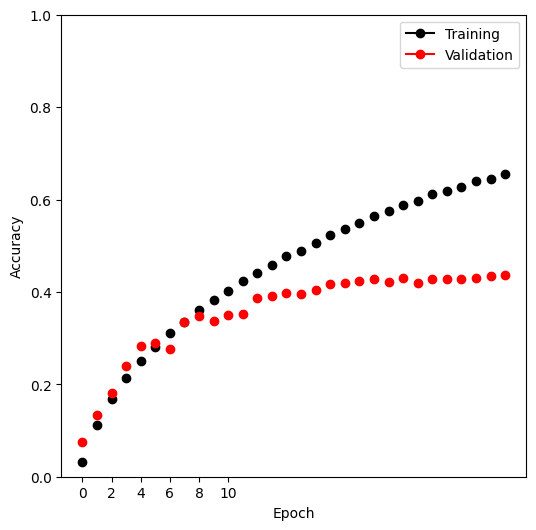

In [70]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)

fig, ax = subplots(1, 1, figsize=(6, 6))

summary_plot(
    cifar_results,
    ax,
    col='accuracy',
    ylabel='Accuracy'
)
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

In [71]:
cifar_trainer.test(
    cifar_module,
    datamodule=cifar_dm
)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.43479999899864197    │
│         test_loss         │     2.392415761947632     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.392415761947632, 'test_accuracy': 0.43479999899864197}]

In [72]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
        cifar_trainer_mps = Trainer(
            accelerator='mps',
            deterministic=True,
            max_epochs=30
        )
        cifar_trainer_mps.fit(cifar_module, datamodule=cifar_dm)
        cifar_trainer_mps.test(cifar_module, datamodule=cifar_dm)
except:
    pass

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing: |                                                                                                    …

## Using pretrained CNN models

In [75]:
resize = Resize((232,232))
crop = CenterCrop(224)
normalize = Normalize(
    [0.485,0.456,0.406],
    [0.229,0.224,0.225]
)
imgfiles = sorted([f for f in glob('/Users/esten/Downloads/book_images/*')])
imgs = torch.stack(
    [torch.div(crop(resize(read_image(f))), 255) for f in imgfiles]
)
imgs = normalize(imgs)
imgs.size()

torch.Size([6, 3, 224, 224])

In [76]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

summary(
    resnet_model,
    input_data=imgs,
    col_names=['input_size', 'output_size', 'num_params']
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/esten/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:04<00:00, 22.8MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [77]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [78]:
img_preds = resnet_model(imgs)

In [79]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [81]:
labs = json.load(open('/Users/esten/Downloads/imagenet_class_index.json'))
class_labels = pd.DataFrame(
    [(int(k), v[1]) for k, v in labs.items()],
    columns=['idx', 'label']
)
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [82]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: /Users/esten/Downloads/book_images/Cape_Weaver.jpg
      label      prob
0   jacamar  0.297499
1     macaw  0.068107
2  lorikeet  0.051105
Image: /Users/esten/Downloads/book_images/Flamingo.jpg
            label      prob
0        flamingo  0.609515
1       spoonbill  0.013586
2  American_egret  0.002132
Image: /Users/esten/Downloads/book_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184682
1           robin  0.084021
2  great_grey_owl  0.061274
Image: /Users/esten/Downloads/book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.453833
1  great_grey_owl  0.015914
2             jay  0.012210
Image: /Users/esten/Downloads/book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097196
2  Tibetan_terrier  0.032820
Image: /Users/esten/Downloads/book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


In [83]:
del(
    cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer
)